In [1]:
%cd ~/repositories/degen_discovery/operon_sr/

/Users/lucas/repositories/degen_discovery/operon_sr


/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoperon.sklearn import SymbolicRegressor
import multiprocessing
import csv
from sklearn.metrics import r2_score
import string
import sys
import sympy
import esr.generation.generator

import jax
import jax.numpy as jnp


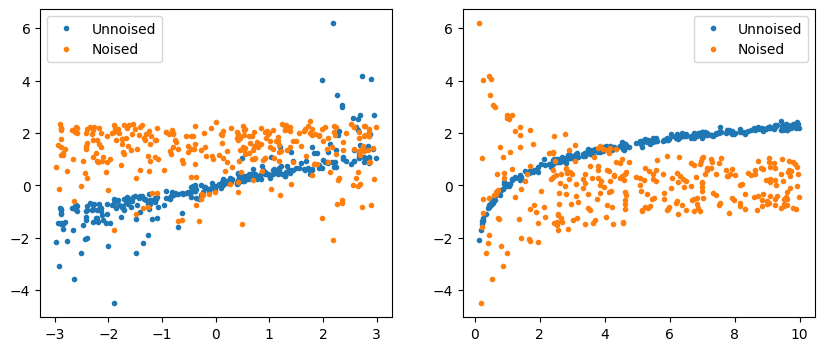

In [135]:


# generate some fake data and noise ("true" flattening coordinates)

np.random.seed(0)
nsamp = 300

def eta(X):
    return jnp.stack([X[:, 0] / jnp.sqrt(X[:, 1]), jnp.log(X[:, 1])]).T
    
    
def eta_jax(X):
    return jnp.array([X[0] / jnp.sqrt(X[1]), jnp.log(X[1])])

def onejac(fn, X):
    return jax.jacrev(fn)(X)


# generate data and some gradient with error
mu = np.random.uniform(low=-3.0, high=3.0, size=nsamp)
var = np.random.uniform(low=0.1, high=10, size=nsamp)
X = np.stack([mu, var], -1)
y = eta(X)

sigy = np.random.uniform(0.05, 0.1, size=y.shape)
y = y + (sigy * np.random.normal(size=y.shape))


myjac = lambda x: onejac(eta_jax, x)
dy = jax.vmap(myjac)(X)
dJ = np.random.uniform(0.1, 0.5, size=(dy.shape))

dy += (dJ *  np.random.normal(size=dy.shape))

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(X[:,0], y[:, 0], '.', label='Unnoised')
axs[1].plot(X[:,1], y[:, 1], '.', label='Unnoised')
axs[0].plot(X[:,0], y[:, 1], '.', label='Noised')
axs[1].plot(X[:,1], y[:, 0], '.', label='Noised')
for ax in axs:
    ax.legend()

#y = y + sigy * np.random.randn(len(y))


# -------


In [40]:
y.shape, sigy.shape

In [155]:
# Some parameters for operon
parent_dir = 'toy_results/'

allowed_symbols = 'add,mul,div,sqrt,pow,log,exp,constant,variable'
epsilon = 1e-3
max_length = 50
time_limit = 20  # s
objectives=['rmse', 'length']
max_evaluations=1e8
generations=1e8



In [156]:


if not os.path.isdir(parent_dir):
    os.mkdir(parent_dir)

n_components = 2


for i in range(n_components):

    out_dir = parent_dir + "component_%d"%(i+1)
    
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
        
    reg = SymbolicRegressor(
                allowed_symbols=allowed_symbols,
                offspring_generator='basic',
                optimizer_iterations=1000,
                max_length=max_length,
                initialization_method='btc',
                n_threads=multiprocessing.cpu_count(),
                objectives = objectives,
                epsilon = epsilon,
                random_state=None,
                reinserter='keep-best',
                max_evaluations=int(max_evaluations),
                symbolic_mode=False,
                time_limit=int(time_limit),
                generations=int(generations),
                add_model_scale_term           = True,
                add_model_intercept_term       = True,

                # uncertainty=sigy,
    )

    yfit = y[:, i]

    print('Fitting')
    reg.fit(X, yfit)
    print('Done')
    print(reg.get_model_string(reg.model_, 2))
    print(reg.stats_)


    # Save Pareto front
    with open(f'{out_dir}/pareto.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        
        print(f'Outputting {len(reg.pareto_front_)} individuals on Pareto front')
        
        for i in range(len(reg.pareto_front_)):
            writer.writerow([reg.pareto_front_[i]['tree'].Length,
                            reg.pareto_front_[i]['mean_squared_error'],
                            reg.pareto_front_[i]['model'],
                            ])
            
    # Save population
    print(f'Outputting {len(reg.individuals_)} individuals in population')
    with open(f'{out_dir}/final_population.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        for ind in reg.individuals_[:reg.population_size]:
            tree = ind.Genotype
            
            # Get name but block printing to sys.stderr
            sys.stderr = open(os.devnull, 'w')
            s = reg.get_model_string(ind.Genotype, 10)
            sys.stderr = sys.__stderr__
            
            y_pred = reg.evaluate_model(tree, X)
            mse = np.mean((yfit - y_pred)**2)
            
            writer.writerow([tree.Length,
                            mse,
                            s
                            ])

Fitting
Done
(0.01 + (1.00 * ((0.06 * X1) / sqrt((0.00 * X2)))))
{'model_length': 4, 'model_complexity': 8, 'generations': 39, 'evaluation_count': 0, 'residual_evaluations': 979373, 'jacobian_evaluations': 812038, 'random_state': 3730003307238307756}
Outputting 29 individuals on Pareto front
Outputting 2000 individuals in population
Fitting
Done
(0.02 + (0.99 * log((1.00 * X2))))
{'model_length': 2, 'model_complexity': 4, 'generations': 152, 'evaluation_count': 0, 'residual_evaluations': 1692433, 'jacobian_evaluations': 1253021, 'random_state': 8163742490742053818}
Outputting 36 individuals on Pareto front
Outputting 2000 individuals in population


In [157]:
import sympy

In [158]:
def split_by_punctuation(s):
    """
    Convert a string into a list, where the string is split by punctuation,
    excluding underscores or full stops.
    
    For example, the string 'he_ll*o.w0%rl^d' becomes
    ['he_ll', '*', 'o.w0', '%', 'rl', '^', 'd']
    
    Args:
        :s (str): The string to split up
        
    Returns
        :split_str (list[str]): The string split by punctuation
    
    """
    pun = string.punctuation.replace('_', '') # allow underscores in variable names
    pun = string.punctuation.replace('.', '') # allow full stops
    pun = pun + ' '
    where_pun = [i for i in range(len(s)) if s[i] in pun]
    if len(where_pun) > 0:
        split_str = [s[:where_pun[0]]]
        for i in range(len(where_pun)-1):
            split_str += [s[where_pun[i]]]
            split_str += [s[where_pun[i]+1:where_pun[i+1]]]
        split_str += [s[where_pun[-1]]]
        if where_pun[-1] != len(s) - 1:
            split_str += [s[where_pun[-1]+1:]]
    else:
        split_str = [s]
        
    # Remove spaces
    split_str = [s.strip() for s in split_str if len(s) > 0 and (not s.isspace())]
    
    return split_str

def is_float(s):
    """
    Function to determine whether a string has a numeric value
    
    Args:
        :s (str): The string of interest
        
    Returns:
        :bool: True if s has a numeric value, False otherwise
        
    """
    try:
        float(eval(s))
        return True
    except:
        return False

def replace_floats(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    split_str = split_by_punctuation(s)
    values = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:
            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(','^']):
            values[i] *= -1
            split_str[idx-1] = ''

    # Rejoin string
    replaced = ''.join(split_str)

    return replaced, values


def compute_DL(eq, idx):

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                }
    
    expr, pars = replace_floats(eq)
    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )
    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])


    def myloss(p):
        ypred = eq_jax(*p, *X.T)

        #myeq = lambda x1,x2: eq_jax(*p, x1,x2)
        myeq = lambda *args: eq_jax(*p, *args)

        # # THIS IS FOR A SINGLE COMPONENT
        yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
        Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T 

        # print("Jpred", Jpred.shape)
        result = jnp.sum((dy[:, idx, :] - Jpred)**2 / 2 / dJ[:, idx, :]**2)
        
        # NEED TO TAKE SLICE OF NUMERICAL JACOBIAN
        return result
    
    neglogL = myloss(pars)
    #all_logL[i] = neglogL
    
    if len(pars) == 0:
        param_codelen = 0
    else:
        theta_ML = np.array(pars)

        # Compute loss and Hessian
        hessian_myloss = jax.hessian(myloss)
        I_ii = np.diag(np.array(hessian_myloss(pars)))

        # Check the Hessian is valid
        #if np.any(I_ii < 0):
        #   return c, latex_expr, neglogL, np.nan
            
        # Remove parameters which do not affect the likelihood or zero parameters
        kept_mask = (I_ii > 0) & (theta_ML != 0)
        theta_ML = theta_ML[kept_mask]
        I_ii = I_ii[kept_mask]
        
        # If the error is bigger than the parameter value, we can just set the
        # precision to the parameter value
        Delta = np.sqrt(12./I_ii)
        nsteps = np.abs(np.array(theta_ML))/Delta
        m = nsteps < 1
        I_ii[m] = 12 / theta_ML[m] ** 2
        
        # Compute parameter part of codelength
        p = len(theta_ML)
        param_codelen = -p/2.*np.log(3.) + np.sum( 0.5*np.log(I_ii) + np.log(abs(np.array(theta_ML))) )
    
    # Combine the terms
    # print("aifeyn", aifeyn)
    # print("neglogL", neglogL)
    # print("param code length", param_codelen)
    DL = neglogL + aifeyn + param_codelen
    
    return c, latex_expr, neglogL, DL, 

In [153]:
data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")[::10]
data.shape

analysing 1 of 2 components
21070.12109375
21075.287109375
8427.8720703125
335.30523681640625
348.8920593261719
343.9776306152344
356.74456787109375
353.4580383300781
366.71441650390625
360.8041687011719
373.3139343261719
6177.64697265625
7515.2978515625
10645.072265625
6628.16552734375
44154.86328125
10652.1904296875
11964.826171875
7912.63427734375
6706.798828125
9023.9423828125
9663.2646484375
2027.2919921875
14772.6416015625
53754.234375
20439.2890625
16242.8662109375
11087.8408203125
7499.26708984375
Best equation: (0.006715 + (0.999828 * ((0.058140 * X1) / sqrt((0.003362 * X2)))))


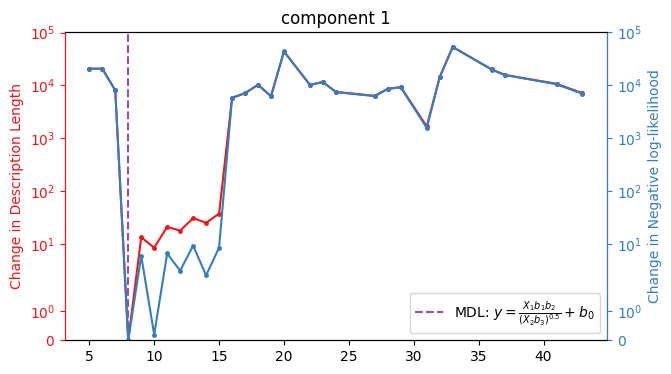

analysing 2 of 2 components
2109.0771484375
309.8505554199219
319.1905822753906
3171.40087890625
21476.923828125
33154.0859375
57530.32421875
57592.3828125
4320.27783203125
13556.2802734375
25218.298828125
56399.546875
42216.84375
86110.1171875
25095.65234375
40707.36328125
17186.59375
11896626.0
69232.6171875
45765.62109375
61220.92578125
1769613.125
10827762.0
10815898.0
279582.3125
37658.74609375
120402.9296875
120983.71875
99975.25
77576.109375
46991.5234375
131986.84375
123163.140625
119494.5859375
106134.5546875
93251.0234375
Best equation: (0.016242 + (0.988614 * log((0.999243 * X2))))


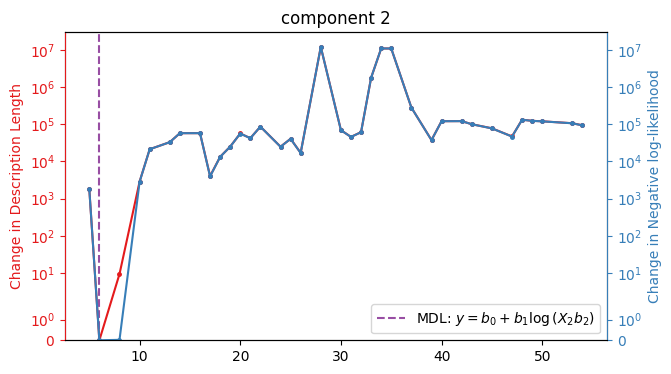

In [159]:
# Find what PySR got as the best one
# if os.path.isfile('my_results.pkl'):
#     model = PySRRegressor.from_file('my_results.pkl')
# else:
#     model = PySRRegressor.from_file(
#         'my_results.csv',
#         nout = 1,
#         n_features_in=X.shape[1],
#         **pysr_args
#     )
# hof = model.get_hof()
# pysr_ibest = np.argmin(hof['score'][1:]) + 1


for idx in range(n_components):

    print("analysing %d of %d components"%(idx+1, n_components))

    outdir = parent_dir + "component_%d/"%(idx + 1)
    # Find what description length (arXiv:2211.11461, Eq. 6) gives
    data = pd.read_csv(outdir + 'pareto.csv', delimiter=";")
    complexity = np.array(data["length"])
    #sorted_idx = np.argsort(complexity)
    loss = np.array(data["mse"])
    eqs = list(np.array(data['model']))

    all_DL = np.ones(len(eqs)) * np.inf
    all_logL = np.ones(len(eqs)) * np.inf
    all_latex = [None] * len(eqs)

    for i, eq in enumerate(eqs):
        #try:
            c, all_latex[i], all_logL[i], all_DL[i] = compute_DL(eq, idx)

            print(all_DL[i])
        #except:
        #    all_latex[i], all_logL[i], all_DL[i] = "", np.inf, np.inf
        
    # Only changes in DL and logL matter
    all_DL -= np.amin(all_DL)
    all_logL -= np.amin(all_logL)

    # Print the best found equation
    ibest = np.argmin(all_DL)
    print('Best equation:', eqs[ibest])

    fig, ax1 = plt.subplots(1, 1, figsize=(7,4), sharex=True)
    cm = plt.get_cmap('Set1')
    ax2 = ax1.twinx()
    ax1.plot(complexity, all_DL, marker='.', color=cm(0), markersize=5)
    ax2.plot(complexity, all_logL, marker='.', color=cm(1), markersize=5)

    ax1.set_ylabel('Change in Description Length')
    ax2.set_ylabel('Change in Negative log-likelihood')
    ax1.yaxis.label.set_color(cm(0))
    ax1.tick_params(axis='y', colors=cm(0))
    ax2.spines['left'].set_color(cm(0))

    ax2.yaxis.label.set_color(cm(1))
    ax2.tick_params(axis='y', colors=cm(1))
    ax2.spines['right'].set_color(cm(1))

    ax1.set_yscale('symlog')
    ax2.set_yscale('symlog')
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)

    #ax1.axvline(complexity[pysr_ibest], color=cm(2), ls=':', label=r'Score: $y = %s$'%all_latex[pysr_ibest])
    ax1.axvline(complexity[ibest], color=cm(3), ls='--', label=r'MDL: $y = %s$'%all_latex[ibest])
    ax1.legend()
    plt.title("component %d"%(idx + 1))
    plt.show()
    #fig.savefig('function_ranking.png', bbox_inches='tight', facecolor='white')


In [115]:
all_DL

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [47]:
all_logL

array([nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
esr.generation.generator.string_to_node()